# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Arabic Words OCR</p>

In [31]:
!pip install torchsummary
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")

# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">HyperParameters</p>

In [15]:
trainig_path = 'char_sample/'
IMAGE_SIZE=(32,32)
batch_size=32
learning_rate = 0.0008
epochs=50
num_classes=29

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Load the dataset</p>

In [16]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    
    return data_transformation

In [17]:
trainset=datasets.ImageFolder(trainig_path,transform=images_transforms('training'))
trainset, testset = torch.utils.data.random_split(trainset, [101621, 25406])
testset, valset = torch.utils.data.random_split(testset, [24000, 1406])
len(trainset)

101621

In [18]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Image Visualization</p>

In [19]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

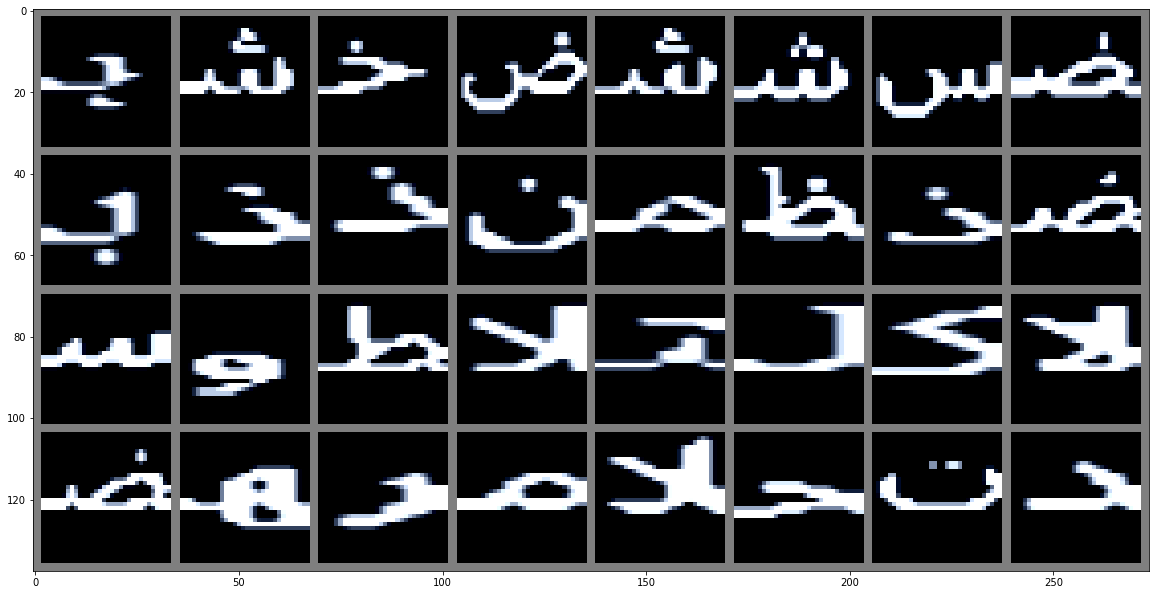

In [20]:
examples = iter(train_loader)
images,labels = examples.next()
imshow(torchvision.utils.make_grid(images))

# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Model Initialization</p>

In [21]:
def Convlayer(in_channels,out_channels,kernel_size,padding=1,stride=1):
    conv =  nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    return conv
class NeuralNet(nn.Module):
    def __init__(self,num_classes):
        super(NeuralNet,self).__init__()
        
        self.conv1 = Convlayer(in_channels=3,out_channels=128,kernel_size=3)
        self.conv2 = Convlayer(in_channels=128,out_channels=64,kernel_size=3)
        self.conv3 = Convlayer(in_channels=64,out_channels=32,kernel_size=3)
        self.conv4 = Convlayer(in_channels=32,out_channels=16,kernel_size=3)
        self.conv5 = Convlayer(in_channels=16,out_channels=8,kernel_size=3)

        self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(8*1*1, 128),
                nn.ReLU(inplace=True),
#                 nn.BatchNorm1d(128),
                nn.Dropout(0.4),
                nn.Linear(128, num_classes)
        )
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.classifier(x)
        return x
    
        

In [22]:
model = NeuralNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
       BatchNorm2d-2          [-1, 128, 32, 32]             256
              ReLU-3          [-1, 128, 32, 32]               0
         MaxPool2d-4          [-1, 128, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          73,792
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 32, 8, 8]          18,464
      BatchNorm2d-10             [-1, 32, 8, 8]              64
             ReLU-11             [-1, 32, 8, 8]               0
        MaxPool2d-12             [-1, 32, 4, 4]               0
           Conv2d-13             [-1, 16, 4, 4]           4,624
      BatchNorm2d-14             [-1, 1

In [36]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()
            
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
            
        plt.figure(figsize=(16,16))
        acc = classification_report(y_actual,y_pred,target_names=list(np.unique(trainset.dataset.classes)))
        cm = confusion_matrix(y_actual, y_pred)
        cm=sns.heatmap(cm, annot=True)
        cm.xaxis.set_ticklabels(list(np.unique(trainset.dataset.classes)))
        cm.yaxis.set_ticklabels(list(np.unique(trainset.dataset.classes)))
        plt.show()
        print(f"{acc}")

def train(model,train_loader,criterion,optimizer,val_loader,epochs=25):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    min_loss = np.Inf

    since = time.time()
    y_actual=[]
    y_pred=[]
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()
            
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [37]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(model,train_loader,criterion,optimizer,val_loader,5)

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH 1/5 Train loss: 0.022903,Validation loss: 0.010304, Train AUC: 0.9945  Validation AUC: 0.9945
  
----------


  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH 2/5 Train loss: 0.019747,Validation loss: 0.005965, Train AUC: 0.9953  Validation AUC: 0.9954
  
----------


  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH 3/5 Train loss: 0.017299,Validation loss: 0.008689, Train AUC: 0.9959  Validation AUC: 0.9959
  
----------


  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH 4/5 Train loss: 0.016596,Validation loss: 0.007105, Train AUC: 0.9962  Validation AUC: 0.9962
  
----------


  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH 5/5 Train loss: 0.014111,Validation loss: 0.009797, Train AUC: 0.9967  Validation AUC: 0.9967
  
----------
Training completed in 33m 34s
Best validation accuracy: 0.996710


# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Model Evaluation</p>

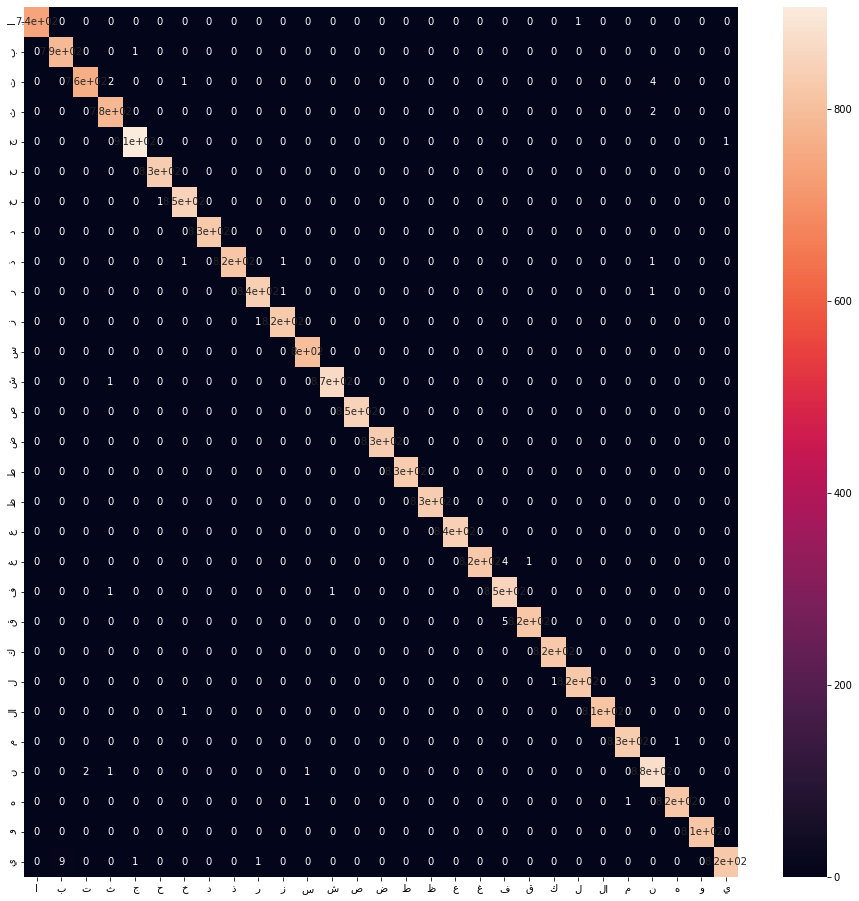

              precision    recall  f1-score   support

           ا       1.00      1.00      1.00       744
           ب       0.99      1.00      0.99       790
           ت       1.00      0.99      0.99       771
           ث       0.99      1.00      1.00       786
           ج       1.00      1.00      1.00       907
           ح       1.00      1.00      1.00       833
           خ       1.00      1.00      1.00       848
           د       1.00      1.00      1.00       828
           ذ       1.00      1.00      1.00       820
           ر       1.00      1.00      1.00       839
           ز       1.00      1.00      1.00       826
           س       1.00      1.00      1.00       799
           ش       1.00      1.00      1.00       868
           ص       1.00      1.00      1.00       849
           ض       1.00      1.00      1.00       834
           ط       1.00      1.00      1.00       830
           ظ       1.00      1.00      1.00       833
           ع       1.00    

In [38]:
test(model,test_loader)

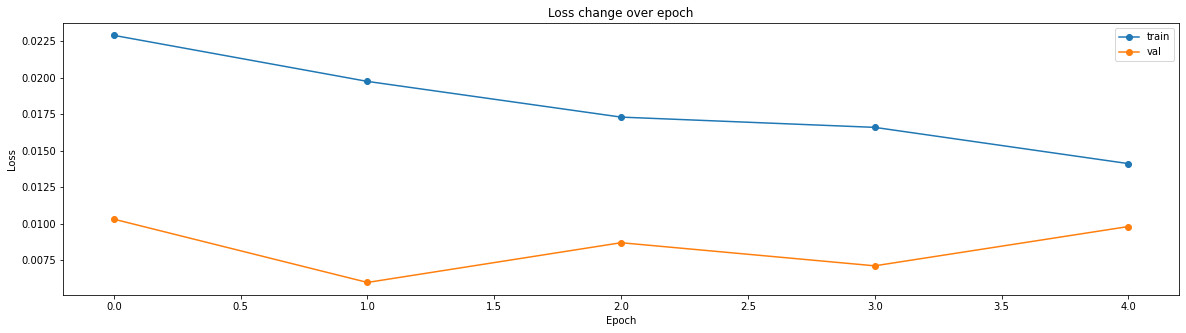

In [39]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

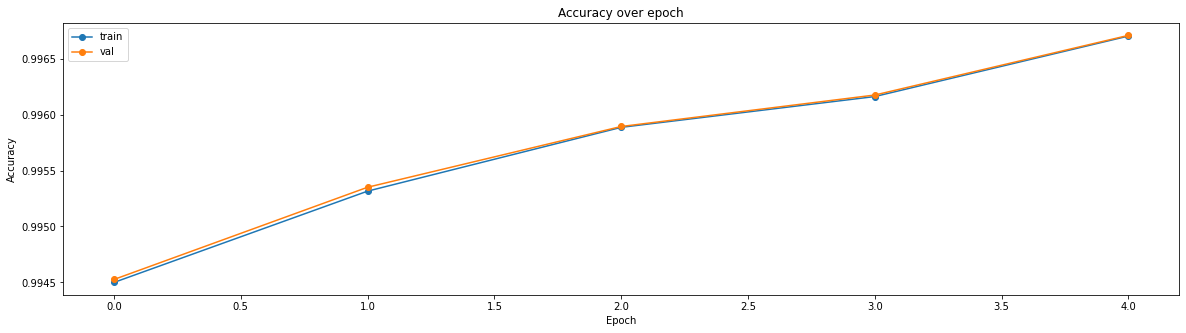

In [40]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

In [ ]:
torch.save(model.state_dict(), 'model.pt')